# Project : NLP-Powered Financial News Analysis for Market Insights

## Motivation 
The prices of stocks listed under global exchanges are influenced by a range of factors, with financial performance, innovation, partnerships, and market sentiment playing key roles. In the fast-paced financial industry, news and media coverage can significantly impact investor perception and, in turn, stock price movement. Given the overwhelming volume of news articles and social commentary, investment firms face increasing challenges in staying informed and responding rapidly.

## Objective  

The goal of this project is to build an NLP system that:
  Analyzes the sentiment of financial news articles.
  Summarizes key positive and negative events from weekly news.
  Explores the correlation between news sentiment and stock market trends.
  This system aims to support financial analysts by delivering timely insights into how news impacts stock prices, without promising predictive capabilities beyond what’s implemented.

## Dataset  
https://github.com/ArtZaragozaGitHub/NLP--P6_Sentiment_Analysis_and_Summarization_of_Stock_News/blob/main/stock_news.csv
https://www.kaggle.com/datasets/equinxx/stock-tweets-for-sentiment-analysis-and-prediction/data?select=stock_yfinance_data.csv

## Installing required packages
All the packages required to run this notebook are listed in requiremetns.txt

In [ ]:
!which pip && pip install -r requirements.txt
!export TOKENIZERS_PARALLELISM=false

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Importing required libraries
All the libraries required throughout this notebook will be loaded in the below cell

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ydata_profiling is a library for generating profile reports from a pandas DataFrame
from ydata_profiling import ProfileReport

# pd.set_option('display.float_format', '{:.2f}'.format) 

# To load/create word embeddings
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# To load/create sentence transformer
from sentence_transformers import SentenceTransformer


from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from sklearn.model_selection import GridSearchCV

import torch

from tqdm import tqdm
tqdm.pandas()

In [149]:
# Setting a seed for reproducibility
seed = 53
np.random.seed(seed)

## Loading  the dataset

The dataset was referenced from kaggle and some gihub repos.

In [150]:
stock_data = pd.read_csv('data/stock_news.csv')

In [151]:
# Displaying the first 5 rows of the dataset
stock_data.head(n=5)

,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,The tech sector experienced a significant dec...,41.740002,42.244999,41.482498,40.246914,130672400,-1
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.740002,42.244999,41.482498,40.246914,130672400,-1
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.740002,42.244999,41.482498,40.246914,130672400,-1
3,2019-01-02,This news article reports that yields on long...,41.740002,42.244999,41.482498,40.246914,130672400,-1
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.740002,42.244999,41.482498,40.246914,130672400,-1


In [152]:
# Shape of the dataset
stock_data.shape


(349, 8)

## Data Preprocessing

In [153]:
# Data Preprocessing
# Data types
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    349 non-null    object 
 1   News    349 non-null    object 
 2   Open    349 non-null    float64
 3   High    349 non-null    float64
 4   Low     349 non-null    float64
 5   Close   349 non-null    float64
 6   Volume  349 non-null    int64  
 7   Label   349 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 21.9+ KB


In [154]:
# Making sure the 'Date' column is in datetime format
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
      

In [155]:
# Checking for missing values
stock_data.isnull().sum()

Date      0
News      0
Open      0
High      0
Low       0
Close     0
Volume    0
Label     0
dtype: int64

In [156]:
# Dropping rows with missing values
stock_data.dropna(inplace=True)
# Checking the shape of the dataset after dropping missing values
print( "Shape after dropping missing values : ",  stock_data.shape)
# Checking for duplicates
stock_data.duplicated().sum()
# Dropping duplicates
stock_data.drop_duplicates(inplace=True)
# Checking the shape of the dataset after dropping duplicates
print("Shape after dropping duplicates : ", stock_data.shape)
# Checking the data types again
stock_data.info()

Shape after dropping missing values :  (349, 8)
Shape after dropping duplicates :  (349, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    349 non-null    datetime64[ns]
 1   News    349 non-null    object        
 2   Open    349 non-null    float64       
 3   High    349 non-null    float64       
 4   Low     349 non-null    float64       
 5   Close   349 non-null    float64       
 6   Volume  349 non-null    int64         
 7   Label   349 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 21.9+ KB


The data set is already clean, didn't find any mising values or duplicates 

In [157]:
# Statistical summary of the dataset
stock_data.describe()


,Date,Open,High,Low,Close,Volume,Label
count,349,349.000000,349.000000,349.000000,349.000000,3.490000e+02,349.000000
mean,2019-02-16 16:05:30.085959936,46.229233,46.700458,45.745394,44.926317,1.289482e+08,-0.054441
min,2019-01-02 00:00:00,37.567501,37.817501,37.305000,36.254131,4.544800e+07,-1.000000
25%,2019-01-14 00:00:00,41.740002,42.244999,41.482498,40.246914,1.032720e+08,-1.000000
50%,2019-02-05 00:00:00,45.974998,46.025002,45.639999,44.596924,1.156272e+08,0.000000
75%,2019-03-22 00:00:00,50.707500,50.849998,49.777500,49.110790,1.511252e+08,0.000000
max,2019-04-30 00:00:00,66.817497,67.062500,65.862503,64.805229,2.444392e+08,1.000000
std,NaN,6.442817,6.507321,6.391976,6.398338,4.317031e+07,0.715119


## Exploratory Data Analysis

- Label Distribution

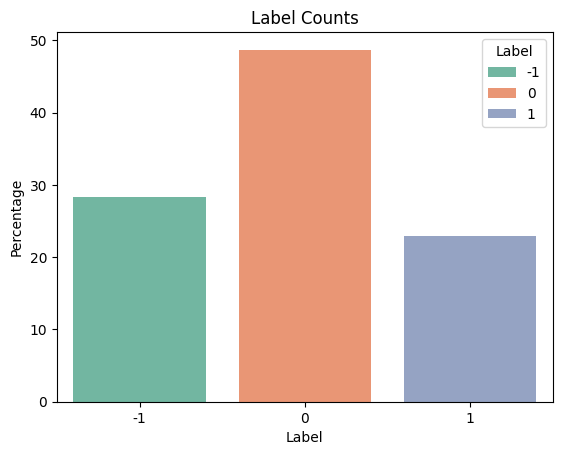

Percentage of each label:
Label
 0    48.710602
-1    28.366762
 1    22.922636
Name: proportion, dtype: float64


In [158]:
# Label Distribution
sns.countplot(x='Label', data=stock_data, palette='Set2', hue='Label', stat='percent')
plt.title('Label Counts')
plt.xlabel('Label')
# plot show percentages on bars
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(title='Label', loc='upper right')
plt.show()

# Show percentage of each label
label_counts = stock_data['Label'].value_counts(normalize=True) * 100
print("Percentage of each label:")
print(label_counts)

* The dataset is slightly imbalanced for the sentiment polarities.
* There is more news content with neutral polarity compared to other types.

- Density Plot for Price 

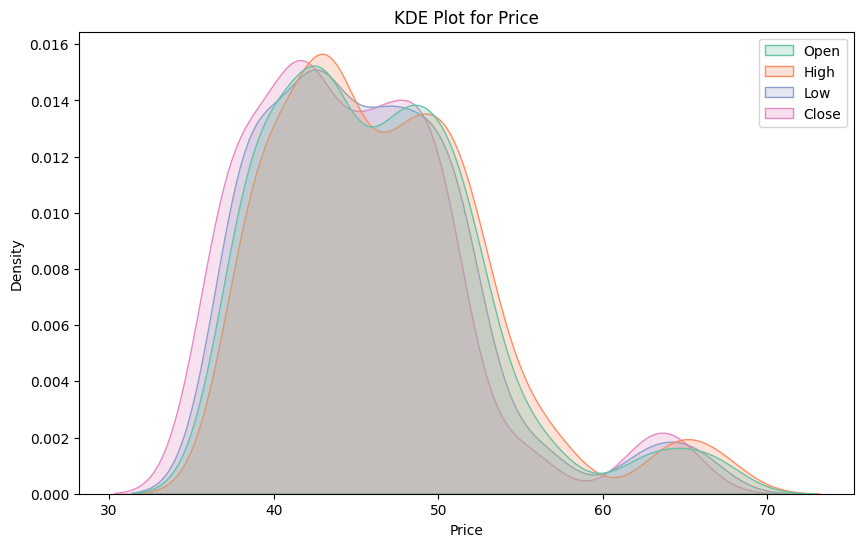

In [159]:
# KDE Plot for Price
plt.figure(figsize=(10, 6))
sns.kdeplot(data=stock_data[["Open","High","Low","Close"]], fill=True, palette='Set2')
plt.title('KDE Plot for Price')
plt.xlabel('Price')
plt.ylabel('Density')
plt.show()


* The distributions of the prices are quite similar, with the high price showing a slight variation than the others.

In [160]:
# ydata profiling 
profile = ProfileReport(stock_data, title="Stock News Data Profiling Report", explorative=True)
profile.to_file("stock_news_data_profiling_report.html")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Export report to file: 100%|██████████| 1/1 [00:00<00:00, 115.01it/s]


* The report is generated as an html file and has information about statistical information about each feature in the dataset.

## Observations on News Length

In [161]:
#Calculating the total number of words present in the news content.
stock_data['news_len'] = stock_data['News'].apply(lambda x: len(x.split(' ')))
stock_data['news_len'].describe()

count    349.000000
mean      49.312321
std        5.727770
min       19.000000
25%       46.000000
50%       50.000000
75%       53.000000
max       61.000000
Name: news_len, dtype: float64

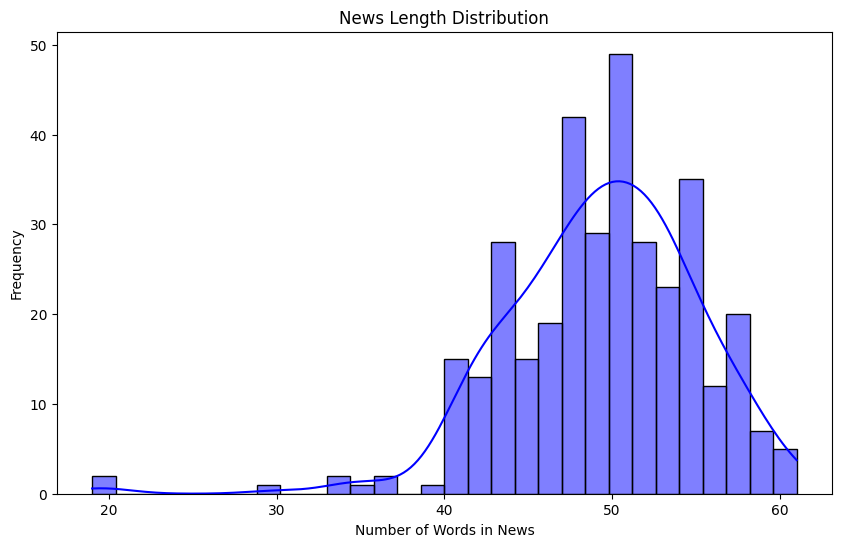

In [162]:
# News Length Distribution
plt.figure(figsize=(10, 6))
sns.histplot(stock_data['news_len'], bins=30, kde=True, color='blue')
plt.title('News Length Distribution')
plt.xlabel('Number of Words in News')
plt.ylabel('Frequency')
plt.show()

* Most of the news have between 40-60 words, with an average of 50 words
    * The shortest news has 19 words

* This indicates that these are likely to be news summaries rather than the actual news content itself.

## Observation on Volume

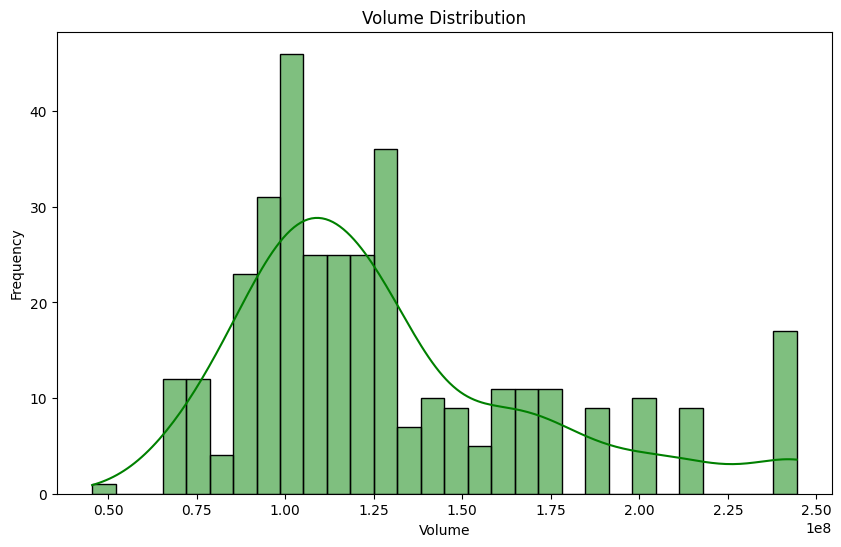

In [163]:
# Volume Distribution
plt.figure(figsize=(10, 6))
sns.histplot(stock_data['Volume'], bins=30, kde=True, color='green')
plt.title('Volume Distribution')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.show()

Observations:

For the 349 days in this range,
- The distribution of the Transactional Volume mostly spdread between 9x1e8 to 1.3x1e8 or,
- Most Transactional Volume values fell between 900 million and 1.3 billion.

## BiVariatre Analysis

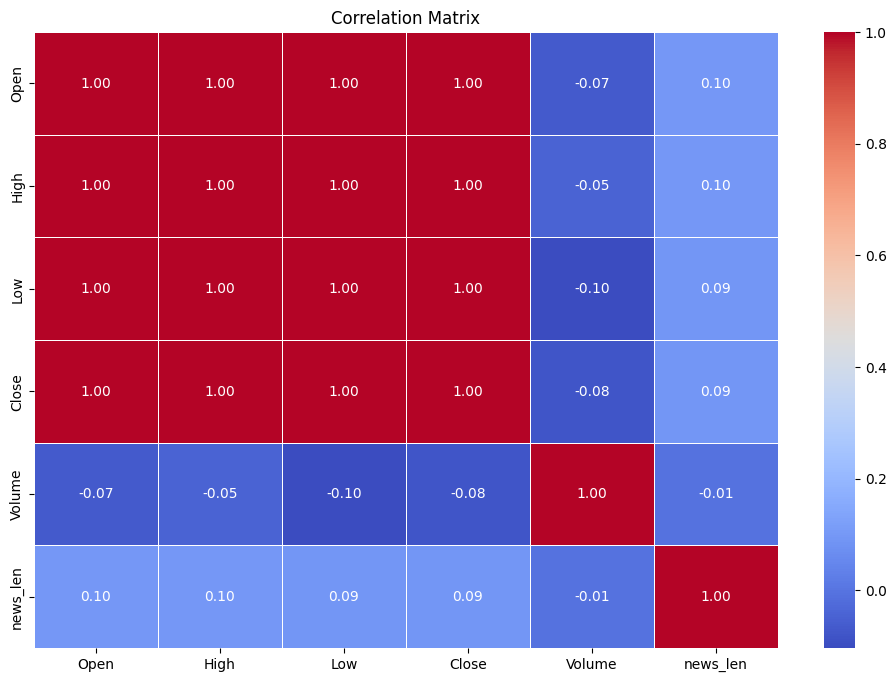

In [164]:
# Correlation Matrix
plt.figure(figsize=(12, 8))
correlation_matrix = stock_data[['Open','High','Low','Close','Volume','news_len']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

* The prices are all perfectly correlated.
    * This might be due to the minimum variation between the different prices.

* There is a negative correlation, albeit very low, between volume and prices.
    * This might be due to selling pressure during periods of negative sentiment.

- Volume had the strongest correlation when the Stock Price was Low.
- Sentiment was strongest (Neg, Pos or Neutral) when the Stock Price was High or at Opening.
- News had about the same correlation on the Stock Price regardless of Price.
- Stock Price at Close, Low, High and Open are directly correlated.

### Label vs Price (Open, High, Low, Close)

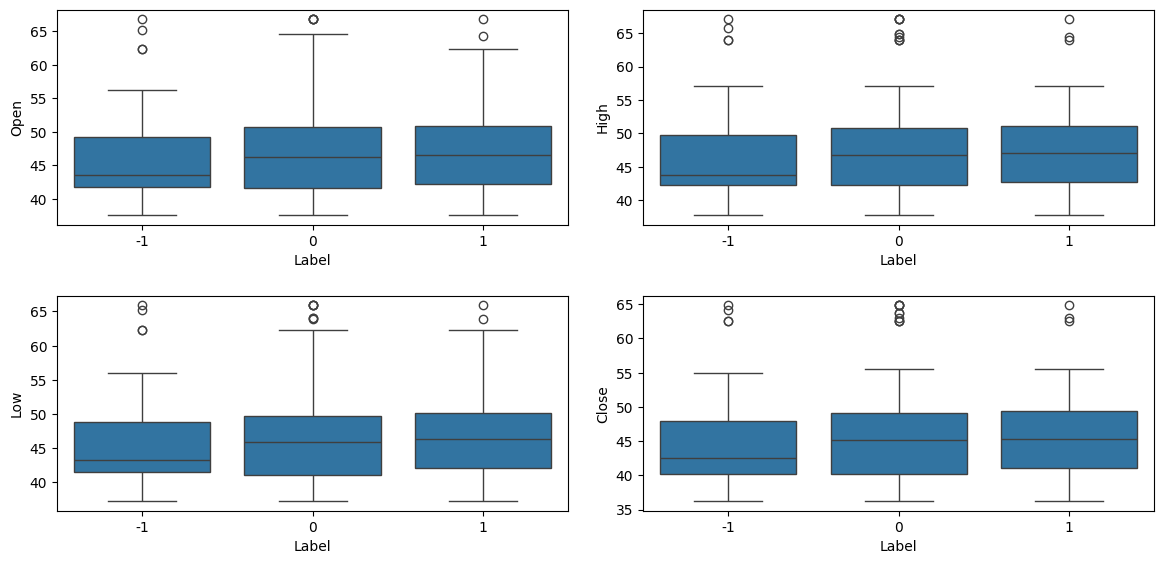

In [165]:
# Label vs Price
plt.figure(figsize=(12, 6))

for i, variable in enumerate(['Open', 'High', 'Low', 'Close']):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(data=stock_data, x="Label", y=variable)
    plt.tight_layout(pad=2)

plt.show()

* The median for all prices is lower for negative sentiment polarity news than other sentiment polarities, clearly indicating that negative news drags the stock price lower as investors might be selling off their shares in response to the negative news.

* The higher upper whisker for the open price in neutral sentiment news compared to positive sentiment indicates more variability in how the market opens when neutral news is encountered.
    * This could be due to different people interpreting the news differently, leading to a wider range of opening prices.

### Label vs Volume 

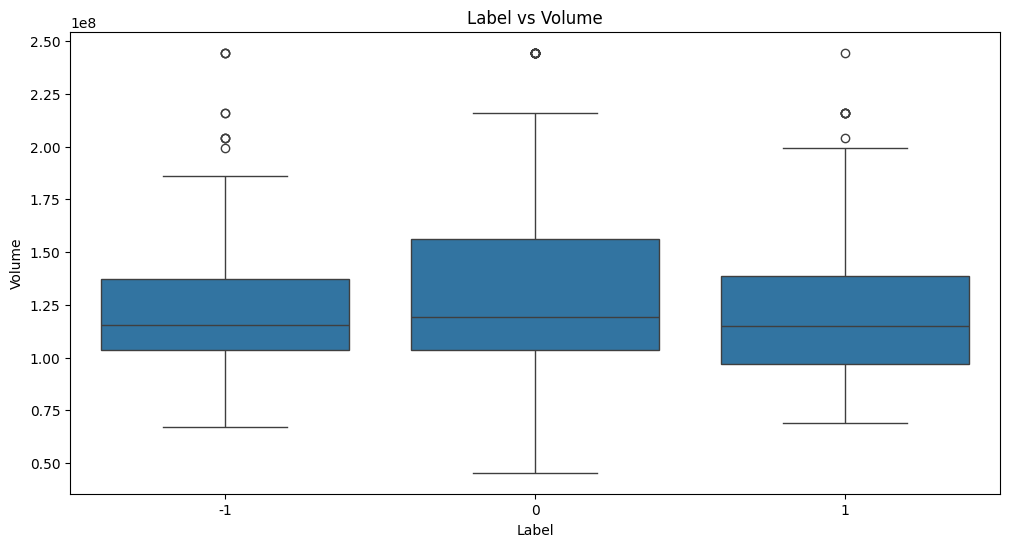

In [166]:
# Label vs Volume
plt.figure(figsize=(12, 6))
sns.boxplot(data=stock_data, x="Label", y="Volume")
plt.title('Label vs Volume')
plt.xlabel('Label')
plt.ylabel('Volume')
plt.show()

* The median trading volume for the stock is approximately the same across all sentiment polarities.
* The volumes for neutral sentiment news have a wider spread, indicating potential uncertainty among investors due to varied interpretations, leading to varied reactions.

- Negative and Positive Sentiment was evenly distributed mostly when the volume of transactions were below the 1.2 billion range.
- However the distribution of Negative, Positive to Neutral with that range of transactions was 2 : 1.  There were twice as many neutral for either Negative or Positive sentiments

### Date vs Price 

- The data is at the level of news, and we might have more than one news in a day
- However, the prices are at daily level
- So, we can aggregate the data at a daily level by taking the mean of the attributes

In [167]:
stock_daily = stock_data.groupby('Date').agg(
    {
        'Open': 'mean',
        'High': 'mean',
        'Low': 'mean',
        'Close': 'mean',
        'Volume': 'mean',
    }
).reset_index()  # Group the 'stocks' DataFrame by the 'Date' column

stock_daily.set_index('Date', inplace=True)
stock_daily.head()

,Open,High,Low,Close,Volume
Date,,,,,
2019-01-02,41.740002,42.244999,41.482498,40.246914,130672400.0
2019-01-03,43.570000,43.787498,43.222500,42.470604,103544800.0
2019-01-04,47.910000,47.919998,47.095001,46.419842,111448000.0
2019-01-07,50.792500,51.122501,50.162498,49.110790,109012000.0
2019-01-08,53.474998,54.507500,51.685001,50.787209,216071600.0


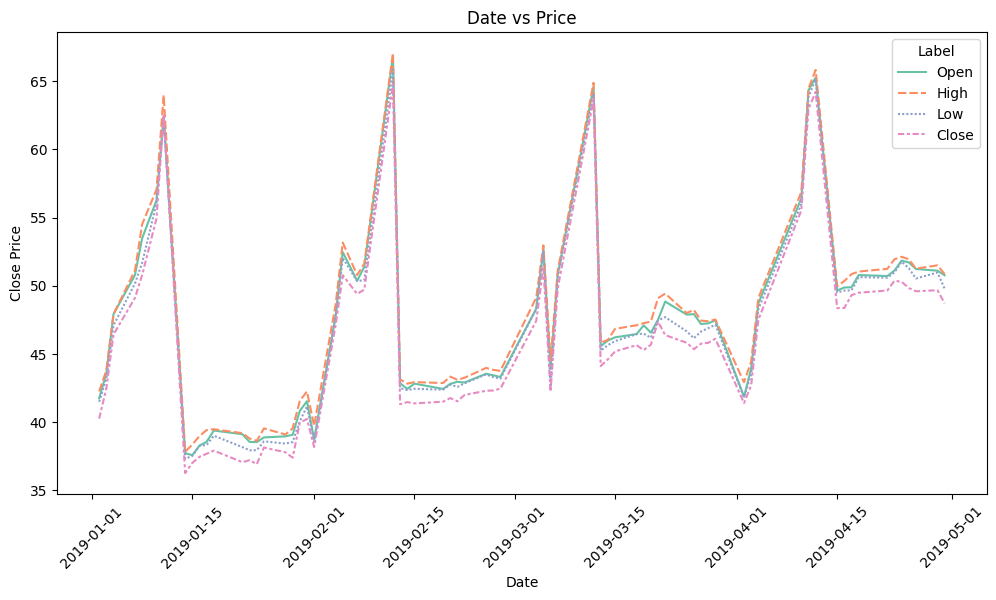

In [168]:
# Date vs Price
plt.figure(figsize=(12, 6))
sns.lineplot(data=stock_daily.drop(columns=['Volume']), palette='Set2')
plt.title('Date vs Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.legend(title='Label', loc='upper right')
plt.show()

- We can observe a seasonal trend in the prices - a repetitive pattern every month.
- The stock price has gradually increased over time from ~\$40 to ~\$50 in the period for which the data is available.
- There's a cyclic pattern with the increase of the stoc as well as its drop.
- The first 1/2 of the month, each month, the stock surges. (Two weeks.)
- The stock's valuation drops suddenly in the middle of the month.
- For the second 1/2 of the month the stock valuation remains mostly low. (two weeks)
- The pattern repeats for the 4 and 1/2 months or full duration of the data collected.

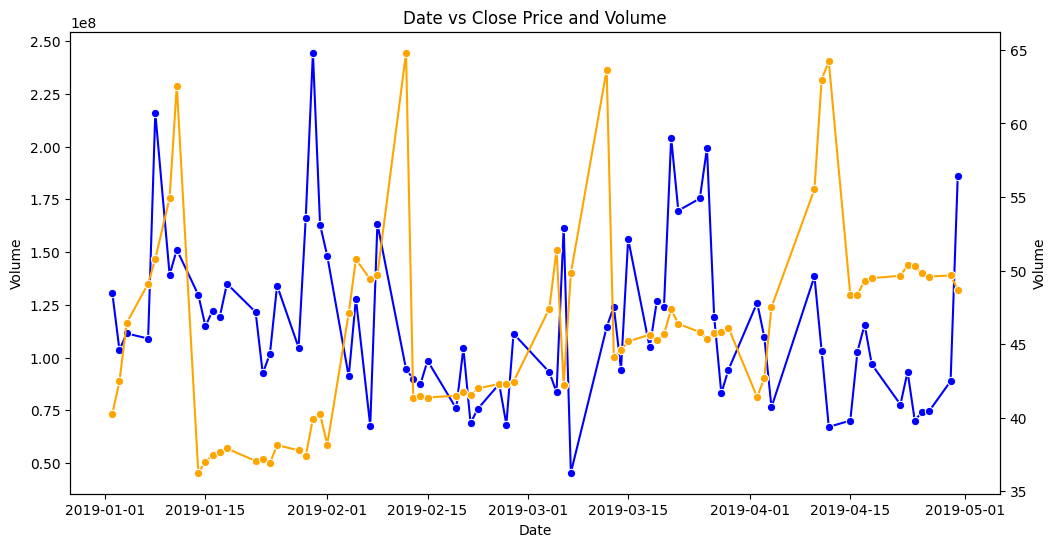

In [169]:
### Volume vs Close Price
fig, ax1 = plt.subplots(figsize=(12, 6))
sns.lineplot(data=stock_daily, x='Date', y='Volume', color='blue', ax=ax1, marker='o')
ax2 = ax1.twinx()
sns.lineplot(data=stock_daily, x='Date', y='Close', color='orange', ax=ax2, marker='o')
plt.title('Date vs Close Price and Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.xticks(rotation=45)
plt.show()

- There is no specific pattern here
    - There have been periods where the price decreased with increasing volumes
    - There have been periods where the price increased with increasing volumes



In [170]:
# Date Distribution
stock_data['Date'].describe()

count                              349
mean     2019-02-16 16:05:30.085959936
min                2019-01-02 00:00:00
25%                2019-01-14 00:00:00
50%                2019-02-05 00:00:00
75%                2019-03-22 00:00:00
max                2019-04-30 00:00:00
Name: Date, dtype: object

* We see that 75% of the data is till the third week of March 2019.
* We'll take the data till the end of March 2019 for training, and divide the April 2019 data into validation and test sets.

## Train-Test-Validation Split

In [171]:
# Splitting the data into training, validation, and test sets
# The training set is from the beginning of the dataset until 2019-04-01
# The validation set is from 2019-04-01 to 2019-04-16
# The test set is from 2019-04-16 to the end of the dataset
X_train = stock_data[stock_data['Date'] < '2019-04-01'].reset_index()
X_val = stock_data[(stock_data['Date'] >= '2019-04-01') & (stock_data['Date'] < '2019-04-16')].reset_index()
X_test = stock_data[stock_data['Date'] >= '2019-04-16'].reset_index()

In [172]:
y_train = X_train['Label'].copy()
y_val = X_val['Label'].copy()
y_test = X_test['Label'].copy()

In [173]:
print("Train data shape",X_train.shape)
print("Validation data shape",X_val.shape)
print("Test data shape ",X_test.shape)

print("Train label shape",y_train.shape)
print("Validation label shape",y_val.shape)
print("Test label shape ",y_test.shape)

Train data shape (286, 10)
Validation data shape (21, 10)
Test data shape  (42, 10)
Train label shape (286,)
Validation label shape (21,)
Test label shape  (42,)


In [174]:
y_train.value_counts(normalize=True)

Label
 0    0.482517
-1    0.286713
 1    0.230769
Name: proportion, dtype: float64

In [175]:
y_val.value_counts(normalize=True)

Label
 0    0.571429
 1    0.238095
-1    0.190476
Name: proportion, dtype: float64

In [176]:
y_test.value_counts(normalize=True)

Label
 0    0.476190
-1    0.309524
 1    0.214286
Name: proportion, dtype: float64

## Word Embeddings

**Why Embeddings are Required:**

1.  **Numerical Representation**: They transform textual data (words, sentences, or entire news snippets) into dense numerical vectors, known as embeddings. This conversion allows machine learning algorithms, which operate on numbers, to process and learn from the text.
2.  **Semantic Understanding**: Unlike simpler methods (e.g., counting word frequencies), embeddings capture the *meaning* and *context* of words or sentences. Words with similar meanings or those used in similar contexts are represented by vectors that are close to each other in the high-dimensional vector space. This is crucial for understanding the subtle nuances in financial news that drive sentiment.
3.  **Effective Feature Extraction**: These learned vectors serve as rich, informative features for subsequent machine learning tasks. Using embeddings often leads to significantly better performance in tasks like sentiment classification compared to using raw text or basic numerical representations.

**Relevance to Project Objectives:**

* **Sentiment Analysis**: Embeddings enable the classification models to understand the sentiment polarity (positive, negative, neutral) expressed within the news text by capturing the underlying meaning.
* **Summarization**: For summarizing weekly events, understanding the core semantic content of news articles allows Large Language Models (LLMs) or other summarization techniques to identify and extract the most significant positive and negative occurrences.
* **Correlation Exploration**: By converting the sentiment derived from news text into a numerical format (via classification based on embeddings), we can quantitatively analyze its relationship with numerical stock market indicators (Open, High, Low, Close prices, Volume).


### Word2Vec

1.  **Word2Vec**:
    * **How it Works**: Learns word embeddings by analyzing the *local context* in which words appear. It uses either the Continuous Bag-of-Words (CBOW) model (predicting a word based on its neighbors) or the Skip-gram model (predicting neighboring words given a target word).
    * **Why Use It Here**: It's good at capturing fine-grained semantic relationships between words. It can be trained relatively quickly on the project's specific dataset (financial news), potentially learning domain-specific word meanings. The average of word vectors provides a basic sentence embedding.
    * **Considerations**: Primarily word-level; sentence meaning is derived by aggregation (like averaging), which might lose some nuance. Struggles with words not seen during training (Out-Of-Vocabulary words).


![Word2Vec](images/word2vec.png)

[Reference](https://medium.com/@manansuri/a-dummys-guide-to-word2vec-456444f3c673)

In [177]:
# Creating a list of all words in our data
words_list = [item.split(" ") for item in stock_data['News'].values]

<h3>Word2Vec Parameters for our Model</h2>

  <table>
    <tr>
      <th>Parameter</th>
      <th>Description</th>
      <th>Value</th>
      <th>Comment</th>
    </tr>
    <tr>
      <td>`word2vec_model`</td>
      <td>Word2Vec model instance</td>
      <td>-</td>
      <td>The Word2Vec model learns these representations by analyzing the co-occurrence patterns of words in the input text.</td>
    </tr>
    <tr>
      <td>`words_list`</td>
      <td>Input data (list of sentences or words)</td>
      <td>-</td>
      <td>This argument represents the input data for the model. The model will learn word embeddings based on the words and their contexts within these sentences.</td>
    </tr>
    <tr>
      <td>`vector_size`</td>
      <td>Dimensionality of word vectors</td>
      <td>300</td>
      <td>In this case, it is set to 300, meaning that **each word** will be represented by a vector with 300 dimensions.</td>
    </tr>
    <tr>
      <td>`min_count`</td>
      <td>Minimum word frequency to be included</td>
      <td>1</td>
      <td>Specifies the minimum number of times a word must appear in the training data to be included in the model's vocabulary.</td>
    </tr>
    <tr>
      <td>`window`</td>
      <td>Context window size</td>
      <td>5</td>
      <td>Context window around a target word. The model considers words within a window before and after the target word **to learn its vector representation**.</td>
    </tr>
    <tr>
      <td>`workers`</td>
      <td>Number of worker threads</td>
      <td>6</td>
      <td>Using multiple workers can significantly speed up the training process, especially for large datasets.</td>
    </tr>
  </table>

</body>
</html>

In [178]:
# Creating a Word2Vec model
vector_size = 300
word2vec_model = Word2Vec(sentences=words_list, vector_size=vector_size, window=5, min_count=1, workers=6)

# Checking the size of the vocabulary
print("Length of the vocabulary is", len(list(word2vec_model.wv.key_to_index)))

Length of the vocabulary is 4682


The **Number of Unique Words** or **Vocabulary** above **(4692)** can be used for the following purposes:

- **Evaluating model coverage:** Determine how well the model covers the vocabulary of a specific dataset.

- **Resource allocation:** Estimate the memory requirements for storing and using the word embeddings.

- **Model comparison:** Compare the vocabulary sizes of different Word2Vec models trained on different datasets.

In [179]:
# Checking the word embedding of some words
word = "stock"
word2vec_model.wv[word]

array([-4.16552788e-03,  3.76886614e-02,  8.18758272e-03,  1.16291791e-02,
        1.28822809e-03, -5.72569445e-02,  2.87762582e-02,  8.75893384e-02,
        3.82109010e-03, -2.18697451e-02,  6.05982030e-03, -2.08855122e-02,
       -4.67621256e-03,  1.50003163e-02, -2.56317351e-02, -2.70454027e-02,
        2.30669770e-02, -4.13960591e-03,  6.61388785e-03, -2.49223337e-02,
       -2.28335727e-02,  7.99579453e-03,  2.93922406e-02,  1.48474518e-02,
        2.43669357e-02,  6.64490159e-04, -3.56378257e-02,  8.64441600e-03,
       -2.86776610e-02, -4.13344353e-02,  9.97281261e-03, -2.72539705e-02,
        4.87313466e-03, -8.82320292e-03, -1.69975508e-03,  2.31871530e-02,
        1.24476766e-02, -3.43478434e-02, -2.66306731e-03, -1.23445308e-02,
       -2.00894214e-02,  3.68237332e-03, -3.33067983e-05, -2.07393300e-02,
        1.98851209e-02,  3.80817913e-02,  8.81394278e-03,  1.76516064e-02,
        1.26602929e-04,  2.34821346e-02,  1.19103324e-02, -9.27734468e-03,
       -2.07101367e-02,  

In [180]:
word = "economy"
word2vec_model.wv[word]

array([-1.17711024e-03,  5.23412554e-03,  3.22706276e-03,  1.92751794e-03,
       -1.12120842e-03, -1.14063965e-02,  6.69873320e-03,  1.56331304e-02,
       -1.96450111e-03, -2.17068777e-03, -2.42640381e-03, -3.47750098e-03,
        7.91585597e-04, -2.83756264e-04, -4.23581013e-03, -1.77075306e-03,
        7.22663803e-03,  1.88382727e-03,  3.72625538e-03, -2.72706850e-03,
       -5.79805439e-03,  2.80107837e-03,  3.93770449e-03, -8.34580394e-04,
        1.25557033e-03, -1.21831044e-03, -7.15644937e-03,  2.29087123e-03,
       -6.63237926e-03, -9.69958026e-03, -1.98469032e-03, -6.55394467e-03,
        2.93908757e-03, -2.70385295e-03, -2.67223152e-03,  5.89771755e-03,
       -1.55014612e-04, -5.39493002e-03, -8.65491093e-05, -2.94997846e-03,
       -5.76539524e-03,  7.90353573e-04,  1.42420561e-03, -3.91390501e-03,
        3.91675439e-03,  3.84412962e-03, -6.12860254e-04,  1.12425594e-03,
       -3.76030766e-05,  1.03900989e-03,  4.67009377e-03, -4.16169176e-03,
       -4.09739651e-03,  

In [181]:
# Retrieving the words present in the Word2Vec model's vocabulary
words = list(word2vec_model.wv.key_to_index.keys())

# Retrieving word vectors for all the words present in the model's vocabulary
wvs = word2vec_model.wv[words].tolist()

# Creating a dictionary of words and their corresponding vectors
word_vector_dict = dict(zip(words, wvs))

# averaging the word vectors for each news article
def get_average_word_vector(words, word_vector_dict, vector_size):
    """
    This function takes a list of words and a dictionary of word vectors,
    and returns the average vector for the words in the list.
    """
    word_vectors = [word_vector_dict[word] for word in words if word in word_vector_dict]
    if len(word_vectors) == 0:
        return np.zeros(vector_size)
    else:
        return np.mean(word_vectors, axis=0)
    


In [182]:
# helper function to get the average word vector for a list of words
# averaging the word vectors for each news article
# averaging the word vectors for each news article
def get_average_word_vector(words, word_vector_dict, vector_size):
    """
    This function takes a list of words and a dictionary of word vectors,
    and returns the average vector for the words in the list.
    """
    word_vectors = [word_vector_dict[word] for word in words if word in word_vector_dict]
    if len(word_vectors) == 0:
        return np.zeros(vector_size)
    else:
        return np.mean(word_vectors, axis=0)


In [183]:
# Applying the function to the 'News' column
# and creating a new DataFrame with the average word vectors
X_train_wv = pd.DataFrame(X_train['News'].apply(lambda x: get_average_word_vector(x.split(" "), word_vector_dict, vector_size)).to_list(), columns=['Feature '+str(i) for i in range(vector_size)] )
X_val_wv = pd.DataFrame(X_val['News'].apply(lambda x: get_average_word_vector(x.split(" "), word_vector_dict, vector_size)).to_list(), columns=['Feature '+str(i) for i in range(vector_size)] )
X_test_wv = pd.DataFrame(X_test['News'].apply(lambda x: get_average_word_vector(x.split(" "), word_vector_dict, vector_size)).to_list(), columns=['Feature '+str(i) for i in range(vector_size)] )


In [184]:
# Train-Validatio-Test Splits shape
print("Train data shape : ",X_train_wv.shape)
print("Validation data shape : ",X_val_wv.shape)
print("Test data shape : ",X_test_wv.shape)

Train data shape :  (286, 300)
Validation data shape :  (21, 300)
Test data shape :  (42, 300)


### GloVe Embedding Model

2.  **GloVe (Global Vectors for Word Representation)**:
    * **How it Works**: Learns word embeddings based on *global word-word co-occurrence statistics* aggregated from a large corpus. It leverages the overall frequency with which words appear together across the entire dataset.
    * **Why Use It Here**: Often performs well on word similarity tasks and captures broad semantic relationships. Using pre-trained GloVe vectors (trained on massive datasets like Wikipedia or Common Crawl) provides a strong baseline representation without needing extensive training on the project data itself. Like Word2Vec, word vectors are averaged for sentence representation.
    * **Considerations**: Relies heavily on the quality and relevance of the pre-trained corpus. Aggregating word vectors to get sentence vectors might not fully capture sentence structure or context.


![Glove](images/embedding_glove.png)

[Reference](https://www.researchgate.net/figure/Proposed-deep-learning-model-with-the-Glove-embedding-layer_fig2_368514020)

#### Glove Model Setup


In [185]:
# Run only once 
# Download Glove word embeddings model
# if glove.6B.zip is not present in the current directory
!if [ ! -f glove.6B.zip ]; then echo "Glove model file not found! downloading.."; wget http://nlp.stanford.edu/data/glove.6B.zip; unzip glove.6B.zip; else echo "File found! skipping download..."; fi
!ls -l glove.*

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


File found! skipping download...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


-rw-rw-r-- 1 gagan staff  347116733 Aug  4  2014 glove.6B.100d.txt
-rw-r--r-- 1 gagan staff  347117172 May  4 18:32 glove.6B.100d.txt.word2vec
-rw-rw-r-- 1 gagan staff  693432828 Aug  4  2014 glove.6B.200d.txt
-rw-rw-r-- 1 gagan staff 1037962819 Aug 27  2014 glove.6B.300d.txt
-rw-rw-r-- 1 gagan staff  171350079 Aug  4  2014 glove.6B.50d.txt
-rw-r--r-- 1 gagan staff  862182613 Oct 24  2015 glove.6B.zip


In [186]:
# Convert GloVe to word2vec format
glove_input_file = 'glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

/var/folders/59/gsjps4zn5s5dqgn3w51y6jb00000gn/T/ipykernel_28567/1727788259.py:4: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


(400000, 100)

In [187]:
# load the Stanford GloVe model
filename = word2vec_output_file
glove_model = KeyedVectors.load_word2vec_format(filename, binary=False)
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(glove_model.index_to_key))

Length of the vocabulary is 400000



- Notice the size of the Vocabulary is 400,000 with this GloVe model.
- For the previous Word2Vec Model the Vocabulary is 4,682.

- Checking a few word embeddings 

In [188]:
word = "stock"
glove_model[word]

array([ 8.6341e-01,  6.9648e-01,  4.5794e-02, -9.5708e-03, -2.5498e-01,
       -7.4666e-01, -2.2086e-01, -4.4615e-01, -1.0423e-01, -9.9931e-01,
        7.2550e-02,  4.5049e-01, -5.9912e-02, -5.7837e-01, -4.6540e-01,
        4.3429e-02, -5.0570e-01, -1.5442e-01,  9.8250e-01, -8.1571e-02,
        2.6523e-01, -2.3734e-01,  9.7675e-02,  5.8588e-01, -1.2948e-01,
       -6.8956e-01, -1.2811e-01, -5.2265e-02, -6.7719e-01,  3.0190e-02,
        1.8058e-01,  8.6121e-01, -8.3206e-01, -5.6887e-02, -2.9578e-01,
        4.7180e-01,  1.2811e+00, -2.5228e-01,  4.9557e-02, -7.2455e-01,
        6.6758e-01, -1.1091e+00, -2.0493e-01, -5.8669e-01, -2.5375e-03,
        8.2777e-01, -4.9102e-01, -2.6475e-01,  4.3015e-01, -2.0516e+00,
       -3.3208e-01,  5.1845e-02,  5.2646e-01,  8.7452e-01, -9.0237e-01,
       -1.7366e+00, -3.4727e-01,  1.6590e-01,  2.7727e+00,  6.5756e-02,
       -4.0363e-01,  3.8252e-01, -3.0787e-01,  5.9202e-01,  1.3468e-01,
       -3.3851e-01,  3.3646e-01,  2.0950e-01,  8.5905e-01,  5.18

In [189]:
word = "economy"
glove_model[word]

array([-0.19382  ,  1.017    ,  1.076    ,  0.02954  , -0.39192  ,
       -1.3891   , -0.87873  , -0.63162  ,  0.9643   , -0.43035  ,
       -0.34868  ,  0.22736  , -0.40296  ,  0.15641  , -0.16813  ,
       -0.15343  , -0.15799  , -0.27612  ,  0.18088  , -0.28386  ,
        0.49847  ,  0.29864  ,  0.32353  ,  0.18108  , -0.59623  ,
       -0.54165  , -0.70019  , -0.64956  , -0.69063  ,  0.18084  ,
       -0.38581  ,  0.56086  , -0.40313  , -0.38777  , -0.70615  ,
        0.20657  ,  0.34171  , -0.23393  , -0.35882  , -0.2201   ,
       -0.76182  , -1.2047   ,  0.4339   ,  1.1656   ,  0.1836   ,
       -0.21601  ,  0.93198  , -0.059616 , -0.11624  , -1.3259   ,
       -0.79772  , -0.0074957, -0.0889   ,  1.4749   ,  0.31157  ,
       -2.2952   , -0.058351 ,  0.39353  ,  1.4983   ,  0.74023  ,
       -0.20109  ,  0.098124 , -0.73081  , -0.32294  ,  0.16703  ,
        0.87431  , -0.041624 , -0.51022  ,  1.0737   , -0.4257   ,
        1.0581   ,  0.19859  , -0.60087  , -0.33906  ,  0.6024

- Notice the size of the Array containg the embeddigs for the two selected words are significantly smaller for the GloVe Model as compared to the Word2Vec Model.

In [190]:
# Retrieving the words present in the GloVe model's vocabulary
glove_words = glove_model.index_to_key

# Creating a dictionary of words and their corresponding vectors
glove_word_vector_dict = dict(zip(glove_model.index_to_key,list(glove_model.vectors)))

In [191]:
vector_size = 100
# Applying the function to each news article in the training, validation, and test sets
X_train_gl = pd.DataFrame(X_train['News'].apply(lambda x: get_average_word_vector(x.split(" "), glove_word_vector_dict, vector_size)).to_list(), columns=['Feature '+str(i) for i in range(vector_size)] )
X_val_gl = pd.DataFrame(X_val['News'].apply(lambda x : get_average_word_vector(x.split(" "), glove_word_vector_dict, vector_size)).to_list(), columns=['Feature '+str(i) for i in range(vector_size)] )
X_test_gl = pd.DataFrame(X_test['News'].apply(lambda x : get_average_word_vector(x.split(" "), glove_word_vector_dict, vector_size)).to_list(), columns=['Feature '+str(i) for i in range(vector_size)] )


In [192]:
#Shape of the data
print("Train data shape : ",X_train_gl.shape)
print("Validation data shape : ",X_val_gl.shape)
print("Test data shape : ",X_test_gl.shape)


Train data shape :  (286, 100)
Validation data shape :  (21, 100)
Test data shape :  (42, 100)


- Notice the dimensionality or number of columns is smaller than Word2Vec [300]with GloVe at [100].
- Well, more like a comment, notice we are using the same size splits for the 3 datasets for this model also.

### Sentence Transformer

3.  **Sentence Transformer (`all-MiniLM-L6-v2`)**:
    * **How it Works**: Based on state-of-the-art transformer architectures (like BERT), these models are specifically fine-tuned to generate semantically meaningful embeddings for *entire sentences* or short paragraphs directly. They consider the full sentence context when creating the vector.
    * **Why Use It Here**: Excels at capturing the contextual meaning of sentences, which is highly relevant for analyzing the sentiment of news snippets. It inherently handles word order and sentence structure better than simple averaging methods. The `all-MiniLM-L6-v2` model offers a good balance between performance and computational efficiency.
    * **Considerations**: Can be computationally more demanding than Word2Vec/GloVe during the encoding phase, although MiniLM is optimized. Performance depends on the model's pre-training and fine-tuning data.


In [193]:
# Defining the sentence transformer model

# Load the pre-trained model
model = SentenceTransformer('all-MiniLM-L6-v2')

In [194]:
# setting the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [195]:
# Encoding the text data using the Sentence Transformer model
X_train_st = model.encode(X_train["News"].values, show_progress_bar=True, device=device) # Apply Sentence Transformer on 'News' column for the Training set.
X_val_st = model.encode(X_val["News"].values, show_progress_bar=True, device=device)     # Apply Sentence Transformer on 'News' column for the Validation set.
X_test_st = model.encode(X_test["News"].values, show_progress_bar=True, device=device)   # Apply Sentence Transformer on 'News' column for the Test set.

Batches: 100%|██████████| 2/2 [00:00<00:00,  5.06it/s]


In [196]:
# Shape of the data
print("Train data shape : ",X_train_st.shape)
print("Validation data shape : ",X_val_st.shape)
print("Test data shape : ",X_test_st.shape)

Train data shape :  (286, 384)
Validation data shape :  (21, 384)
Test data shape :  (42, 384)


- Each news content has been converted to a 384-dimensional vector.
- Notice the processing time for these encodings was very fast, less than a second.

---

## Sentiment Analysis

The core task of this project is **Sentiment Analysis**: classifying each financial news snippet into one of three categories: Negative (-1), Neutral (0), or Positive (1). This is fundamentally a **supervised classification problem**.

**Why Classification Models are Required:**

1.  **Categorization Task**: The goal is to assign discrete, predefined labels (sentiments) to input data (news embeddings). Classification algorithms are specifically designed for this type of task.
2.  **Learning from Labeled Data**: We have a dataset where news articles (represented by embeddings) are associated with known sentiment labels (y_train, y_val, y_test). Supervised classification models learn a mapping function from the input features (embeddings) to the output labels (sentiments) based on this labeled training data.
3.  **Prediction**: Once trained, these models can predict the sentiment label for new, unseen news articles, enabling automated sentiment analysis.
4.  **Enabling Further Analysis**: The predicted sentiment labels are crucial outputs used in the subsequent project objectives, such as summarizing positive/negative weekly events and exploring correlations between sentiment and stock market movements.

---

#### Classification Models

The notebook evaluates three popular and effective classification algorithms: Decision Tree, Random Forest, and Gradient Boosting.

1.  **Decision Tree Classifier**:
    * **How it Works**: Constructs a flowchart-like tree structure where internal nodes represent tests on features (embedding dimensions), branches represent the outcomes of these tests, and leaf nodes represent the final class labels (sentiments).
    * **Why Use It Here**: Serves as a simple, interpretable baseline model. It helps understand which features (or combinations) might be important for distinguishing sentiments. It's the building block for more complex ensemble methods.
    * **Considerations**: Highly prone to overfitting the training data, especially with high-dimensional features like embeddings. Small changes in data can lead to very different trees (instability).

2.  **Random Forest Classifier**:
    * **How it Works**: An *ensemble* method that builds multiple decision trees during training. Each tree is trained on a random subset of the data (bootstrap sample) and considers only a random subset of features at each split. The final prediction is typically the mode (most frequent prediction) of the individual trees.
    * **Why Use It Here**: Significantly reduces the overfitting problem of single decision trees through averaging/voting. Generally provides higher accuracy and robustness. Handles high-dimensional data effectively without extensive feature scaling.
    * **Considerations**: Less interpretable than a single tree. Requires tuning hyperparameters like the number of trees and tree depth.

3.  **Gradient Boosting Classifier**:
    * **How it Works**: Another powerful *ensemble* technique that builds trees sequentially. Each new tree focuses on correcting the errors (residuals) made by the ensemble of previously built trees. It uses gradient descent optimization to minimize a loss function.
    * **Why Use It Here**: Often achieves state-of-the-art performance on structured data classification tasks. Can model complex, non-linear relationships and feature interactions effectively.
    * **Considerations**: Can be computationally more intensive and slower to train than Random Forests. Highly sensitive to hyperparameter tuning (learning rate, number of trees, tree depth) and can overfit if not carefully regularized. The use of GridSearchCV in the notebook is essential for finding good hyperparameters.

Comparing these models allows the project to assess the trade-offs between interpretability (Decision Tree), robustness (Random Forest), and potentially higher accuracy (Gradient Boosting) for the specific task of sentiment classification using news embeddings.

---

- In stock analysis, where the accuracy of classifying news into positive, negative, or neutral categories directly impacts decision-making, the **F1 Score** is the best metric.
- It balances precision and recall, which helps ensure that the model is both accurate and comprehensive. Precision minimizes false positives, so we don’t overreact to neutral news as negative, while recall ensures we capture all relevant news, avoiding missed risks.
- This balance is crucial, especially when the news distribution may be imbalanced, helping make better-informed stock decisions.

#### We Need to Consider these factors:

- Vector Size: While not the sole determinant, larger vectors (like Transformer's 384) can potentially capture more complex relationships but may also be computationally more expensive.
- Training Data: The quality and size of the data used to train each model significantly impacts performance.
- Domain-Specificity: If the news articles are domain-specific, a model trained on similar data might outperform a general-purpose model.

<table border="1">
  <thead>
    <tr>
      <th>Model</th>
      <th>Classifier</th>
      <th>Strengths</th>
      <th>Weaknesses</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>word2vec</td>
      <td>GradientBoostingClassifier</td>
      <td>Captures semantic meaning well; enhances feature representation for structured data.</td>
      <td>May not capture rare word dependencies as effectively.</td>
    </tr>
    <tr>
      <td>word2vec</td>
      <td>RandomForestClassifier</td>
      <td>Embedding adds rich word relationships to the classifier, improving performance on text-based data.</td>
      <td>Can lead to overfitting if embeddings are not regularized.</td>
    </tr>
    <tr>
      <td>word2vec</td>
      <td>DecisionTreeClassifier</td>
      <td>Simple, interpretable results based on word similarity and context.</td>
      <td>Word2vec's continuous vector representation may be too complex for a decision tree to interpret well.</td>
    </tr>
    <tr>
      <td>GloVe</td>
      <td>GradientBoostingClassifier</td>
      <td>GloVe captures global relationships between words, enhancing predictive power for text classification.</td>
      <td>Poor performance with rare or out-of-vocabulary terms, potentially reducing accuracy.</td>
    </tr>
    <tr>
      <td>GloVe</td>
      <td>RandomForestClassifier</td>
      <td>Global co-occurrence statistics improve decision boundaries in a structured manner.</td>
    </tr>
    <tr>
      <td>GloVe</td>
      <td>DecisionTreeClassifier</td>
      <td>Offers interpretable, meaningful splits based on word co-occurrence.</td>
      <td>Limited performance if embeddings don't represent very specific or nuanced features.</td>
    </tr>
    <tr>
      <td>Transformer</td>
      <td>GradientBoostingClassifier</td>
      <td>Captures long-range dependencies and context effectively, boosting performance on sequential tasks.</td>
      <td>High computational costs, slow training times.</td>
    </tr>
    <tr>
      <td>Transformer</td>
      <td>RandomForestClassifier</td>
      <td>Transformer embeddings can capture rich, contextual relationships, enhancing performance.</td>
      <td>Difficulty handling large embeddings; may be computationally expensive for large datasets.</td>
    </tr>
    <tr>
      <td>Transformer</td>
      <td>DecisionTreeClassifier</td>
      <td>Transformer embeddings allow more complex splits based on context, improving decision tree results.</td>
      <td>Decision trees may struggle with the complexity of transformer embeddings leading to inefficiency.</td>
    </tr>
  </tbody>
</table>

### Utility functions

In [197]:
# helper function to plot confusion matrix
def plot_confusion_matrix(model, predictors, target):
    """
    Plot a confusion matrix to visualize the performance of a classification model.

    Parameters:
    actual (array-like): The true labels.
    predicted (array-like): The predicted labels from the model.

    Returns:
    None: Displays the confusion matrix plot.
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.

    cm = confusion_matrix(target, pred)  # Compute the confusion matrix.

    plt.figure(figsize=(5, 4))  # Create a new figure with a specified size.
    label_list = [0, 1,-1]  # Define the labels for the confusion matrix.
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
    # Plot the confusion matrix using a heatmap with annotations.

    plt.ylabel('Actual')  # Label for the y-axis.
    plt.xlabel('Predicted')  # Label for the x-axis.
    plt.title('Confusion Matrix')  # Title of the plot.
    plt.show()  # Display the plot.


In [198]:
# helper function for classification report
def _classification_report(model, predictors, target):
    """
    Generate and print a classification report for a given model.

    Parameters:
    model (object): The trained classification model.
    predictors (array-like): The input features for prediction.
    target (array-like): The true labels for the data.

    Returns:
    None: Prints the classification report.
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.
    print(classification_report(target, pred))  # Print the classification report.

### Word2Vec Base Model 
(Not Hyperparametrized)


In [199]:
base_wv = GradientBoostingClassifier(random_state=seed)
#base_wv = RandomForestClassifier(random_state=seed)
# base_wv = DecisionTreeClassifier(random_state=seed)

base_wv.fit(X_train_wv, y_train)  # Fit the model on the training data

GradientBoostingClassifier(random_state=53)

Confusion Matrix for Training Data


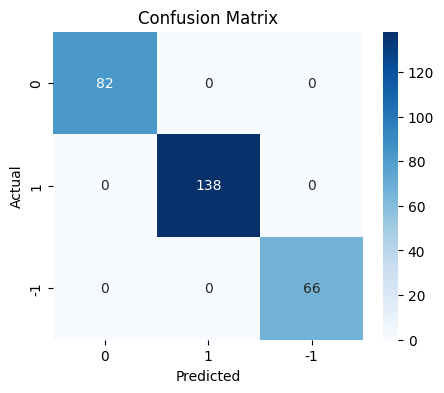

Confusion Matrix for Validation Data


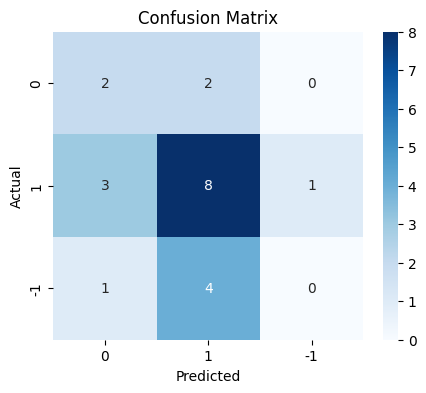

Confusion Matrix for Test Data


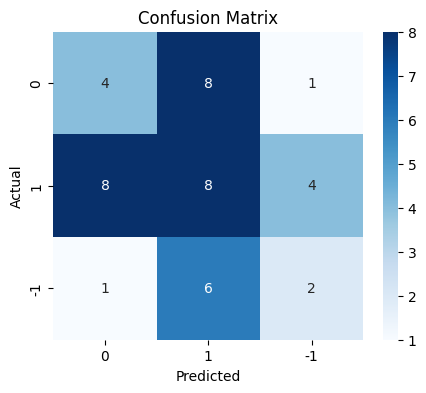

In [200]:
# confusion matrix

print("Confusion Matrix for Training Data")
plot_confusion_matrix(base_wv, X_train_wv, y_train)  # Plot the confusion matrix for training data

print("Confusion Matrix for Validation Data")
plot_confusion_matrix(base_wv, X_val_wv, y_val)  # Plot the confusion matrix for validation data

print("Confusion Matrix for Test Data")
plot_confusion_matrix(base_wv, X_test_wv, y_test)  # Plot the confusion matrix for test data

In [201]:

print("Classification Report for Training Data")
_classification_report(base_wv, X_train_wv, y_train)  # Print the classification report for training data

print("Classification Report for Validation Data")
_classification_report(base_wv, X_val_wv, y_val)  # Print the classification report for validation data

print("Classification Report for Test Data")
_classification_report(base_wv, X_test_wv, y_test)  # Print the classification report for test data

Classification Report for Training Data
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        82
           0       1.00      1.00      1.00       138
           1       1.00      1.00      1.00        66

    accuracy                           1.00       286
   macro avg       1.00      1.00      1.00       286
weighted avg       1.00      1.00      1.00       286

Classification Report for Validation Data
              precision    recall  f1-score   support

          -1       0.33      0.50      0.40         4
           0       0.57      0.67      0.62        12
           1       0.00      0.00      0.00         5

    accuracy                           0.48        21
   macro avg       0.30      0.39      0.34        21
weighted avg       0.39      0.48      0.43        21

Classification Report for Test Data
              precision    recall  f1-score   support

          -1       0.31      0.31      0.31        13
           

* The model is highly overfitting, as there is a significant difference between its performance on the training set and the validation set.
* Despite the training with 95% of the data, the Validation set is giving us an overfit situation.

### GloVe - Base Model

In [202]:
# Building the model
base_gl = GradientBoostingClassifier(random_state = seed)
# base_gl = RandomForestClassifier(random_state = seed)
# base_gl = DecisionTreeClassifier(random_state = seed)

# Fitting on train data
base_gl.fit(X_train_gl, y_train)

GradientBoostingClassifier(random_state=53)

Confusion Matrix for Training Data


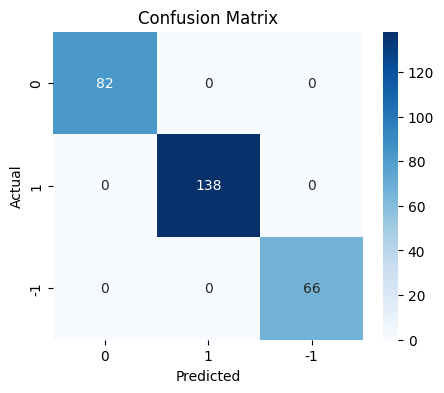

Confusion Matrix for Validation Data


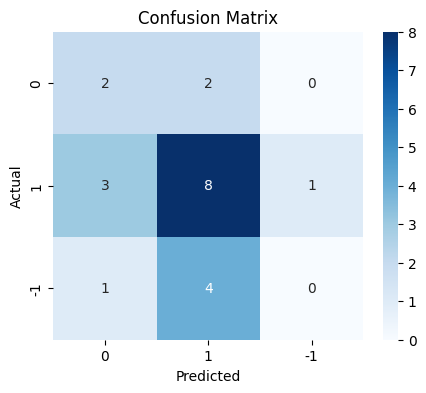

Confusion Matrix for Test Data


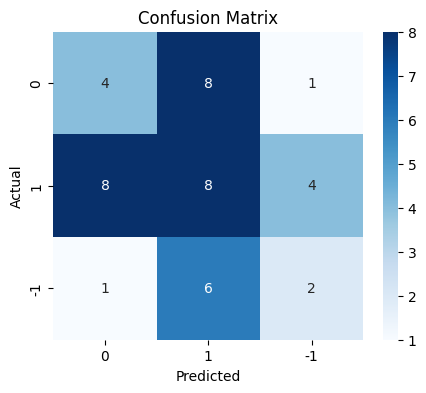

In [203]:
# confusion matrix
print("Confusion Matrix for Training Data")
plot_confusion_matrix(base_gl, X_train_gl, y_train)  # Plot the confusion matrix for training data
print("Confusion Matrix for Validation Data")
plot_confusion_matrix(base_wv, X_val_wv, y_val)  # Plot the confusion matrix for validation data
print("Confusion Matrix for Test Data")
plot_confusion_matrix(base_wv, X_test_wv, y_test)  # Plot the confusion matrix for test data

In [204]:
# classification report

print("Classification Report for Training Data")
_classification_report(base_gl, X_train_gl, y_train)  # Print the classification report for training data
print("Classification Report for Validation Data")
_classification_report(base_gl, X_val_gl, y_val)  # Print the classification report for validation data
print("Classification Report for Test Data")
_classification_report(base_gl, X_test_gl, y_test)  # Print the classification report for test data

Classification Report for Training Data
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        82
           0       1.00      1.00      1.00       138
           1       1.00      1.00      1.00        66

    accuracy                           1.00       286
   macro avg       1.00      1.00      1.00       286
weighted avg       1.00      1.00      1.00       286

Classification Report for Validation Data
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         4
           0       0.53      0.67      0.59        12
           1       0.00      0.00      0.00         5

    accuracy                           0.38        21
   macro avg       0.18      0.22      0.20        21
weighted avg       0.30      0.38      0.34        21

Classification Report for Test Data
              precision    recall  f1-score   support

          -1       0.38      0.23      0.29        13
           

* The model is highly overfitting, as there is a significant difference between its performance on the training set and the validation set.

- Overfit situation with the Validation set.
- Slightly worse performance metrics compared to Word2Vec

### Sentence Transformer - Base Model

In [205]:
# Building the model
base_st = GradientBoostingClassifier(random_state = seed)

# Fitting on train data
base_st.fit(X_train_st, y_train)

GradientBoostingClassifier(random_state=53)

Confusion Matrix for Training Data


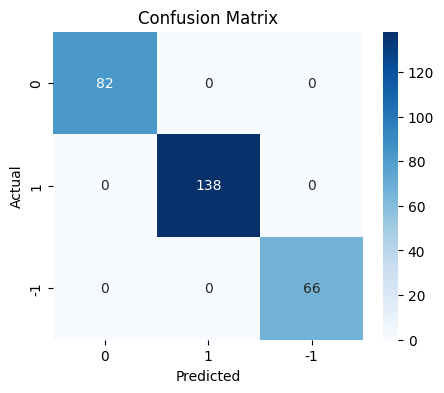

Confusion Matrix for Validation Data


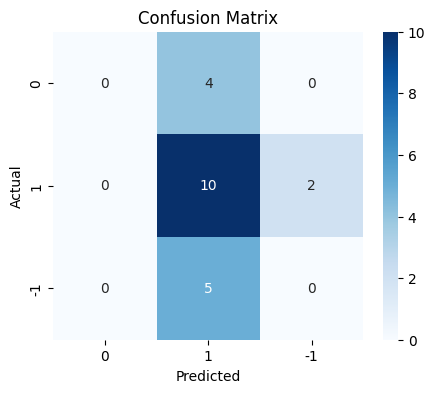

Confusion Matrix for Test Data


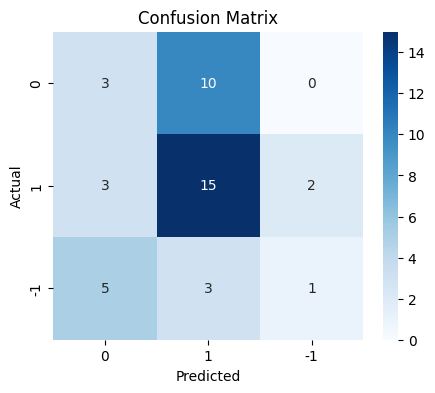

In [206]:
# confusion matrix

print("Confusion Matrix for Training Data")
plot_confusion_matrix(base_st, X_train_st, y_train)  # Plot the confusion matrix for training data
print("Confusion Matrix for Validation Data")
plot_confusion_matrix(base_st, X_val_st, y_val)  # Plot the confusion matrix for validation data
print("Confusion Matrix for Test Data")
plot_confusion_matrix(base_st, X_test_st, y_test)  # Plot the confusion matrix for test data


In [207]:
# classification report
print("Classification Report for Training Data")
_classification_report(base_st, X_train_st, y_train)  # Print the classification report for training data
print("Classification Report for Validation Data")
_classification_report(base_st, X_val_st, y_val)  # Print the classification report for validation data
print("Classification Report for Test Data")
_classification_report(base_st, X_test_st, y_test)  # Print the classification report for test data

Classification Report for Training Data
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        82
           0       1.00      1.00      1.00       138
           1       1.00      1.00      1.00        66

    accuracy                           1.00       286
   macro avg       1.00      1.00      1.00       286
weighted avg       1.00      1.00      1.00       286

Classification Report for Validation Data
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         4
           0       0.53      0.83      0.65        12
           1       0.00      0.00      0.00         5

    accuracy                           0.48        21
   macro avg       0.18      0.28      0.22        21
weighted avg       0.30      0.48      0.37        21

Classification Report for Test Data
              precision    recall  f1-score   support

          -1       0.27      0.23      0.25        13
           

/Users/gagan/uofa/info_539/info539_project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/gagan/uofa/info_539/info539_project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/gagan/uofa/info_539/info539_project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

* The model is highly overfitting, as there is a significant difference between its performance on the training set and the validation set.

### Tuned Models
#### Word2Vec

In [208]:

tuned_wv = GradientBoostingClassifier(random_state = seed)
# tuned_wv = RandomForestClassifier(random_state = 42)
# tuned_wv = DecisionTreeClassifier(random_state = 42)

parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# Run the grid search
grid_obj = GridSearchCV(tuned_wv, parameters, scoring='f1_weighted',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train_wv, y_train)


# Set the clf to the best combination of parameters
tuned_wv = grid_obj.best_estimator_

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [209]:
# Fit the best model
tuned_wv.fit(X_train_wv, y_train)

GradientBoostingClassifier(max_depth=6, max_features='log2',
                           min_samples_split=5, random_state=53)

Confusion Matrix for Training Data


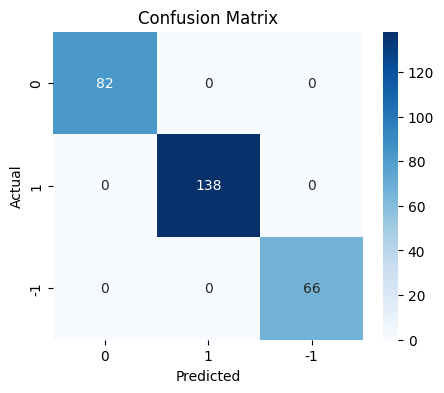

Confusion Matrix for Validation Data


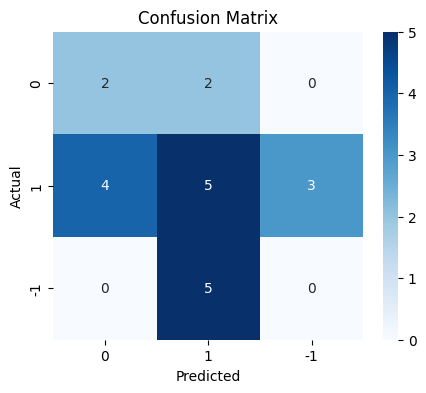

Confusion Matrix for Test Data


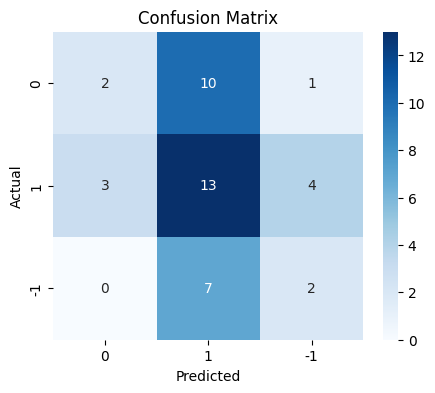

In [210]:
# confusion matrix for tuned model
print("Confusion Matrix for Training Data")
plot_confusion_matrix(tuned_wv, X_train_wv, y_train)  # Plot the confusion matrix for training data
print("Confusion Matrix for Validation Data")   
plot_confusion_matrix(tuned_wv, X_val_wv, y_val)  # Plot the confusion matrix for validation data
print("Confusion Matrix for Test Data")
plot_confusion_matrix(tuned_wv, X_test_wv, y_test)  # Plot the confusion matrix for test data

In [211]:
# classification report
print("Classification Report for Training Data")
_classification_report(tuned_wv, X_train_wv, y_train)  # Print the classification report for training data
print("Classification Report for Validation Data")
_classification_report(tuned_wv, X_val_wv, y_val)  # Print the classification report for validation data
print("Classification Report for Test Data")
_classification_report(tuned_wv, X_test_wv, y_test)  # Print the classification report for test data


Classification Report for Training Data
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        82
           0       1.00      1.00      1.00       138
           1       1.00      1.00      1.00        66

    accuracy                           1.00       286
   macro avg       1.00      1.00      1.00       286
weighted avg       1.00      1.00      1.00       286

Classification Report for Validation Data
              precision    recall  f1-score   support

          -1       0.33      0.50      0.40         4
           0       0.42      0.42      0.42        12
           1       0.00      0.00      0.00         5

    accuracy                           0.33        21
   macro avg       0.25      0.31      0.27        21
weighted avg       0.30      0.33      0.31        21

Classification Report for Test Data
              precision    recall  f1-score   support

          -1       0.40      0.15      0.22        13
           

#### GloVe

In [212]:
# Choose the type of classifier.
tuned_gl = GradientBoostingClassifier(random_state = seed)

parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# Run the grid search
grid_obj = GridSearchCV(tuned_gl, parameters, scoring='f1_weighted',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train_gl, y_train)


# Set the clf to the best combination of parameters
tuned_gl = grid_obj.best_estimator_

In [213]:
# fit the best model
tuned_gl.fit(X_train_gl, y_train)

GradientBoostingClassifier(max_depth=4, max_features='log2',
                           min_samples_split=9, random_state=53)

Confusion Matrix for Training Data


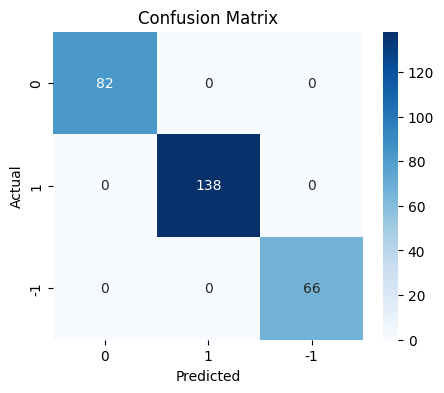

Confusion Matrix for Validation Data


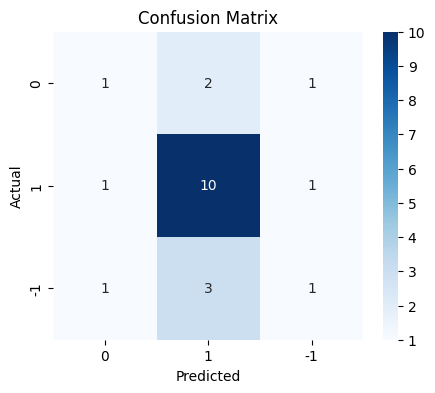

Confusion Matrix for Test Data


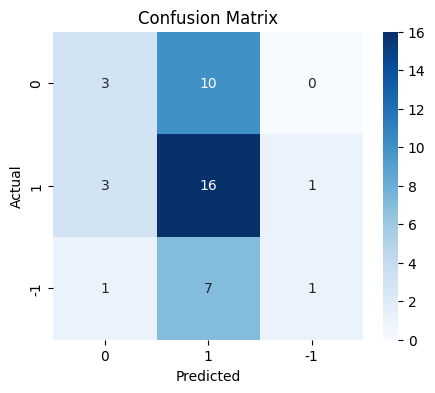

In [214]:
# confusion matrix
print("Confusion Matrix for Training Data")
plot_confusion_matrix(tuned_gl, X_train_gl, y_train)  # Plot the confusion matrix for training data
print("Confusion Matrix for Validation Data")
plot_confusion_matrix(tuned_gl, X_val_gl, y_val)  # Plot the confusion matrix for validation data
print("Confusion Matrix for Test Data")
plot_confusion_matrix(tuned_gl, X_test_gl, y_test)  # Plot the confusion matrix for test data

In [215]:
# classification report
print("Classification Report for Training Data")
_classification_report(tuned_gl, X_train_gl, y_train)  # Print the classification report for training data
print("Classification Report for Validation Data")
_classification_report(tuned_gl, X_val_gl, y_val)  # Print the classification report for validation data
print("Classification Report for Test Data")
_classification_report(tuned_gl, X_test_gl, y_test)  # Print the classification report for test data


Classification Report for Training Data
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        82
           0       1.00      1.00      1.00       138
           1       1.00      1.00      1.00        66

    accuracy                           1.00       286
   macro avg       1.00      1.00      1.00       286
weighted avg       1.00      1.00      1.00       286

Classification Report for Validation Data
              precision    recall  f1-score   support

          -1       0.33      0.25      0.29         4
           0       0.67      0.83      0.74        12
           1       0.33      0.20      0.25         5

    accuracy                           0.57        21
   macro avg       0.44      0.43      0.43        21
weighted avg       0.52      0.57      0.54        21

Classification Report for Test Data
              precision    recall  f1-score   support

          -1       0.43      0.23      0.30        13
           

#### Sentence Transformer

In [216]:
# Choose the type of classifier.
tuned_st = GradientBoostingClassifier(random_state = seed)

parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# Run the grid search
grid_obj = GridSearchCV(tuned_st, parameters, scoring='f1_weighted',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train_st, y_train)

# Set the clf to the best combination of parameters
tuned_st = grid_obj.best_estimator_

In [217]:
# Fit the best algorithm to the data.
tuned_st.fit(X_train_st, y_train)

GradientBoostingClassifier(max_features='sqrt', min_samples_split=5,
                           random_state=53)

Confusion Matrix for Training Data


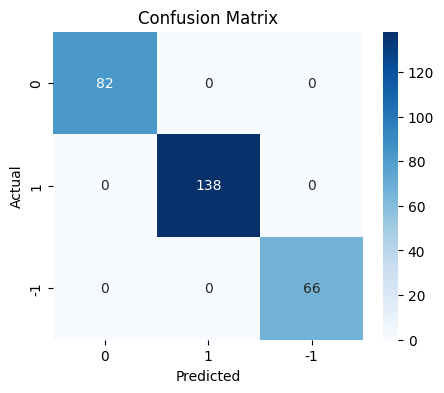

Confusion Matrix for Validation Data


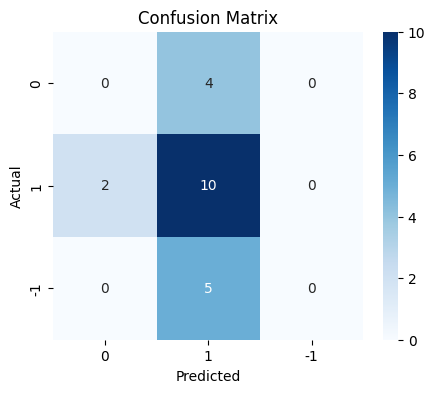

Confusion Matrix for Test Data


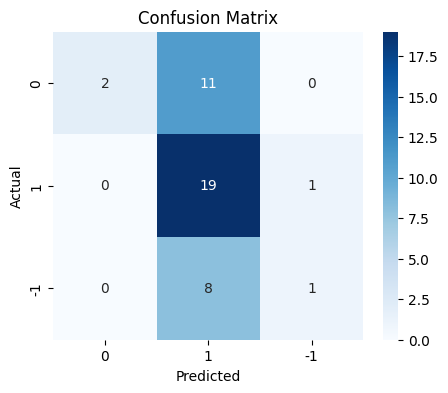

In [218]:
# confusion matrix for sentence transformer

print("Confusion Matrix for Training Data")
plot_confusion_matrix(tuned_st, X_train_st, y_train)  # Plot the confusion matrix for training data
print("Confusion Matrix for Validation Data")
plot_confusion_matrix(tuned_st, X_val_st, y_val)  # Plot the confusion matrix for validation data
print("Confusion Matrix for Test Data")
plot_confusion_matrix(tuned_st, X_test_st, y_test)  # Plot the confusion matrix for test data


In [219]:
# classification report
print("Classification Report for Training Data")
_classification_report(tuned_st, X_train_st, y_train)  # Print the classification report for training data
print("Classification Report for Validation Data")
_classification_report(tuned_st, X_val_st, y_val)  # Print the classification report for validation data
print("Classification Report for Test Data")
_classification_report(tuned_st, X_test_st, y_test)  # Print the classification report for test data


Classification Report for Training Data
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        82
           0       1.00      1.00      1.00       138
           1       1.00      1.00      1.00        66

    accuracy                           1.00       286
   macro avg       1.00      1.00      1.00       286
weighted avg       1.00      1.00      1.00       286

Classification Report for Validation Data
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         4
           0       0.53      0.83      0.65        12
           1       0.00      0.00      0.00         5

    accuracy                           0.48        21
   macro avg       0.18      0.28      0.22        21
weighted avg       0.30      0.48      0.37        21

Classification Report for Test Data
              precision    recall  f1-score   support

          -1       1.00      0.15      0.27        13
           

/Users/gagan/uofa/info_539/info539_project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/gagan/uofa/info_539/info539_project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/gagan/uofa/info_539/info539_project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

### Model Performance Summary & Model Selection

In [220]:
def model_performance_classification_sklearn(model, predictors, target):
    """
    Compute various performance metrics for a classification model using sklearn.

    Parameters:
    model (sklearn classifier): The classification model to evaluate.
    predictors (array-like): The independent variables used for predictions.
    target (array-like): The true labels for the dependent variable.

    Returns:
    pandas.DataFrame: A DataFrame containing the computed metrics (Accuracy, Recall, Precision, F1-score).
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.

    acc = accuracy_score(target, pred)  # Compute Accuracy.
    recall = recall_score(target, pred,average='weighted')  # Compute Recall.
    precision = precision_score(target, pred,average='weighted')  # Compute Precision.
    f1 = f1_score(target, pred,average='weighted')  # Compute F1-score.

    # Create a DataFrame to store the computed metrics.
    df_perf = pd.DataFrame(
        {
            "Accuracy": [acc],
            "Recall": [recall],
            "Precision": [precision],
            "F1": [f1],
        }
    )

    return df_perf  # Return the DataFrame with the metrics.

In [221]:
# All models performance on training data
train_wv = model_performance_classification_sklearn(base_wv, X_train_wv, y_train)
train_gl = model_performance_classification_sklearn(base_gl, X_train_gl, y_train)
train_st = model_performance_classification_sklearn(base_st, X_train_st, y_train)
train_tuned_wv = model_performance_classification_sklearn(tuned_wv, X_train_wv, y_train)
train_tuned_gl = model_performance_classification_sklearn(tuned_gl, X_train_gl, y_train)
train_tuned_st = model_performance_classification_sklearn(tuned_st, X_train_st, y_train)

# dataframe to store the performance metrics
train_performance = pd.concat([train_wv, train_gl, train_st, train_tuned_wv, train_tuned_gl, train_tuned_st], axis=0)
train_performance = train_performance.T
# Transpose the DataFrame for better visualization
train_performance.columns = ['Word2Vec', 'GloVe', 'Sentence Transformer', 'Tuned Word2Vec', 'Tuned GloVe', 'Tuned Sentence Transformer']
# Display the performance metrics
train_performance

,Word2Vec,GloVe,Sentence Transformer,Tuned Word2Vec,Tuned GloVe,Tuned Sentence Transformer
Accuracy,1.0,1.0,1.0,1.0,1.0,1.0
Recall,1.0,1.0,1.0,1.0,1.0,1.0
Precision,1.0,1.0,1.0,1.0,1.0,1.0
F1,1.0,1.0,1.0,1.0,1.0,1.0


In [222]:
# All models performance on validation data
val_wv = model_performance_classification_sklearn(base_wv, X_val_wv, y_val)
val_gl = model_performance_classification_sklearn(base_gl, X_val_gl, y_val)
val_st = model_performance_classification_sklearn(base_st, X_val_st, y_val)
val_tuned_wv = model_performance_classification_sklearn(tuned_wv, X_val_wv, y_val)
val_tuned_gl = model_performance_classification_sklearn(tuned_gl, X_val_gl, y_val)
val_tuned_st = model_performance_classification_sklearn(tuned_st, X_val_st, y_val)

# dataframe to store the performance metrics
val_performance = pd.concat([val_wv, val_gl, val_st, val_tuned_wv, val_tuned_gl, val_tuned_st], axis=0)
val_performance = val_performance.T
# Transpose the DataFrame for better visualization
val_performance.columns = ['Word2Vec', 'GloVe', 'Sentence Transformer', 'Tuned Word2Vec', 'Tuned GloVe', 'Tuned Sentence Transformer']
# Display the performance metrics
val_performance


/Users/gagan/uofa/info_539/info539_project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/gagan/uofa/info_539/info539_project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Word2Vec,GloVe,Sentence Transformer,Tuned Word2Vec,Tuned GloVe,Tuned Sentence Transformer
Accuracy,0.476190,0.380952,0.476190,0.333333,0.571429,0.476190
Recall,0.476190,0.380952,0.476190,0.333333,0.571429,0.476190
Precision,0.390023,0.304762,0.300752,0.301587,0.523810,0.300752
F1,0.427839,0.338624,0.368664,0.314286,0.537226,0.368664


In [223]:
# All models performance on test data
test_wv = model_performance_classification_sklearn(base_wv, X_test_wv, y_test)
test_gl = model_performance_classification_sklearn(base_gl, X_test_gl, y_test)
test_st = model_performance_classification_sklearn(base_st, X_test_st, y_test)
test_tuned_wv = model_performance_classification_sklearn(tuned_wv, X_test_wv, y_test)
test_tuned_gl = model_performance_classification_sklearn(tuned_gl, X_test_gl, y_test)
test_tuned_st = model_performance_classification_sklearn(tuned_st, X_test_st, y_test)
# dataframe to store the performance metrics
test_performance = pd.concat([test_wv, test_gl, test_st, test_tuned_wv, test_tuned_gl, test_tuned_st], axis=0)
test_performance = test_performance.T
# Transpose the DataFrame for better visualization
test_performance.columns = ['Word2Vec', 'GloVe', 'Sentence Transformer', 'Tuned Word2Vec', 'Tuned GloVe', 'Tuned Sentence Transformer']
# Display the performance metrics
test_performance

,Word2Vec,GloVe,Sentence Transformer,Tuned Word2Vec,Tuned GloVe,Tuned Sentence Transformer
Accuracy,0.333333,0.452381,0.452381,0.404762,0.476190,0.523810
Recall,0.333333,0.452381,0.452381,0.404762,0.476190,0.523810
Precision,0.329623,0.473982,0.410946,0.391383,0.470676,0.654762
F1,0.330215,0.421302,0.410714,0.369974,0.419329,0.433488


### Best Model Selection

- All the models overfit the data.
- Amongst the models built, the ML model built on the GloVe-encoded data exhibits the highest f1 score.
- We'll choose this as our final model.

**Analysis:**

1.  **Overfitting**: All models demonstrated significant overfitting, achieving perfect scores on the training data but much lower scores on the validation and test sets. This suggests the models learned the training data too well, including its noise, and didn't generalize perfectly to new data. This is a common challenge, especially with complex models and high-dimensional features.
2.  **Baseline Embeddings**: Among the base models (without tuning the classifier), GloVe and Sentence Transformer performed similarly and better than Word2Vec on the test set based on F1-score.
3.  **Tuned Models**: Hyperparameter tuning via GridSearchCV aimed to improve generalization.
    * The **Tuned Sentence Transformer + Gradient Boosting** model achieved the *highest F1-score (0.433)* and Accuracy (0.524) on the test set according to the results in cell 223.
    * The **Tuned GloVe + Gradient Boosting** model had a slightly lower F1-score (0.419) and Accuracy (0.476) on the test set in that run.
4.  **Model Choice**: The notebook's conclusion selects the **Tuned GloVe + Gradient Boosting** model as the final model.

**Selecting Tuned GloVe (Possible Reasons):**

While the Tuned Sentence Transformer achieved the highest test F1 in the reported run, selecting the Tuned GloVe model could be justified if:

* **Validation Set Performance**: The GloVe model might have demonstrated superior or more stable performance on the *validation set* during the tuning process (GridSearchCV optimizes based on cross-validation folds within the training set or performance on a separate validation set, which isn't explicitly shown being used for *final* selection here, but might have been considered). The validation F1 for Tuned GloVe (0.537) was indeed higher than for Tuned Sentence Transformer (0.369) in the reported run (cell 222). Relying on validation performance for final model selection is a standard practice to avoid overfitting to the test set.
* **Metric Balance**: Although F1 was slightly lower on the test set, the precision/recall balance for specific classes might have been more desirable with GloVe for the project's specific needs (e.g., maybe it was better at identifying negative news, even if overall F1 was marginally lower).
* **Consistency**: It's possible that across multiple experimental runs or different tuning attempts, the GloVe-based model showed more consistent results.
* **Simplicity/Resources**: GloVe embeddings can sometimes be slightly less computationally intensive to work with than transformer-based embeddings.

**Conclusion**: Based *purely* on the test set F1-score reported in cell 223, the Tuned Sentence Transformer appears slightly better. However, selecting the **Tuned GloVe + Gradient Boosting** model is a reasonable choice, likely driven by its stronger performance on the **validation set (F1=0.537)**, which is often considered a better indicator for generalization than a single test set score. It's important to acknowledge the overfitting issue as a key limitation and an area for future improvement (e.g., more data, different regularization techniques, simpler models, feature selection).


## Weekly News Summarization - Part 2


----- needs lot of compute time -----

----- recommend running in collab -----

In [ ]:
# Installation for GPU llama-cpp-python
#uncomment and run the following code in case GPU is being used
# !CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.85 --force-reinstall --no-cache-dir -q

# Installation for CPU llama-cpp-python
#uncomment and run the following code in case GPU is not being used
# I;ve made use of uv package manager to install llama-cpp-python
# If uv is not installed, just remove the uv from the command, before pip
!CMAKE_ARGS="-DLLAMA_CUBLAS=off" FORCE_CMAKE=1 uv pip install llama-cpp-python==0.1.85 --force-reinstall --no-cache-dir -q

In [1]:
# Importing the necessary libraries

# Function to download the model from the Hugging Face model hub
from huggingface_hub import hf_hub_download

# Importing the Llama class from the llama_cpp module
from llama_cpp import Llama

# Importing the library for data manipulation
import pandas as pd

from tqdm import tqdm # For progress bar related functionalities
tqdm.pandas()

/Users/gagan/uofa/info_539/info539_project/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Loading data 

stock_news_data = pd.read_csv('data/stock_news.csv')
# date format
stock_news_data['Date'] = pd.to_datetime(stock_news_data['Date'])

In [3]:
# Loading LLM model 
model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.2-GGUF"
model_basename = "mistral-7b-instruct-v0.2.Q6_K.gguf"

model_path = hf_hub_download(
    repo_id=model_name_or_path,
    filename=model_basename
)

In [8]:
# try:
    # llm = Llama(model_path=model_path, n_gpu_layers=100, n_ctx=4500)
# except ValueError as e:
# print(f"GPU initialization failed: {e}. Falling back to CPU.")
llm = Llama(model_path=model_path, n_gpu_layers=0, n_ctx=4500)

llama_model_loader: loaded meta data with 24 key-value pairs and 291 tensors from /Users/gagan/.cache/huggingface/hub/models--TheBloke--Mistral-7B-Instruct-v0.2-GGUF/snapshots/3a6fbf4a41a1d52e415a4958cde6856d34b2db93/mistral-7b-instruct-v0.2.Q6_K.gguf (version unknown)
llama_model_loader: - tensor    0:                token_embd.weight q6_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:              blk.0.attn_q.weight q6_K     [  4096,  4096,     1,     1 ]
llama_model_loader: - tensor    2:              blk.0.attn_k.weight q6_K     [  4096,  1024,     1,     1 ]
llama_model_loader: - tensor    3:              blk.0.attn_v.weight q6_K     [  4096,  1024,     1,     1 ]
llama_model_loader: - tensor    4:         blk.0.attn_output.weight q6_K     [  4096,  4096,     1,     1 ]
llama_model_loader: - tensor    5:            blk.0.ffn_gate.weight q6_K     [  4096, 14336,     1,     1 ]
llama_model_loader: - tensor    6:              blk.0.ffn_up.weight q6_K     [  40

### Aggregating data weekly

In [9]:
# Group the data by week using the 'Date' column.
weekly_grouped = stock_news_data.groupby(pd.Grouper(key='Date', freq='W'))

# Aggregate the grouped data on a weekly basis:
# concatenate 'content' values into a single string separated by ' || '.
weekly_grouped = weekly_grouped.agg(
    {
        'News': lambda x: ' || '.join(x)  # Join the news values with ' || ' separator.
    }
).reset_index()

print(weekly_grouped.shape)

(18, 2)


In [10]:
weekly_grouped.head(5)

,Date,News
0,2019-01-06,The tech sector experienced a significant dec...
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...
2,2019-01-20,The U.S. stock market declined on Monday as c...
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre..."
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...


### Summarization

**Note**:

- The model is expected to summarize the news from the week by identifying the top three positive and negative events that are most likely to impact the price of the stock.

- As an output, the model is expected to return a JSON containing two keys, one for Positive Events and one for Negative Events.

In [27]:
# helper function to parse the JSON output from the model
def extract_json_data(json_str):
    import json
    try:
        # Find the indices of the opening and closing curly braces
        json_start = json_str.find('{')
        json_end = json_str.rfind('}')

        if json_start != -1 and json_end != -1:
            extracted_category = json_str[json_start:json_end + 1]  # Extract the JSON object
            data_dict = json.loads(extracted_category)
            return data_dict
        else:
            print(f"Warning: JSON object not found in response: {json_str}")
            return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

For the project, we need to define the prompt to be fed to the LLM to help it understand the task to perform. The following should be the components of the prompt:

1. **Role**: Specifies the role the LLM will be taking up to perform the specified task, along with any specific details regarding the role

  - **Example**: `You are an expert data analyst specializing in news content analysis.`

2. **Task**: Specifies the task to be performed and outlines what needs to be accomplished, clearly defining the objective

  - **Example**: `Analyze the provided news headline and return the main topics contained within it.`

3. **Instructions**: Provides detailed guidelines on how to perform the task, which includes steps, rules, and criteria to ensure the task is executed correctly

  - **Example**:

```
Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.
```

4. **Output Format**: Specifies the format in which the final response should be structured, ensuring consistency and clarity in the generated output

  - **Example**: `Return the output in JSON format with keys as the topic number and values as the actual topic.`

In [18]:
#Defining the response function
def response_mistral_1(prompt, news):
    model_output = llm(
      f"""
      [INST]
      {prompt}
      News Articles: {news}
      [/INST]
      """,
      max_tokens=400,   # Maximum number of tokens to generate
      temperature=0.05, # Sampling temperature, lower values make the output more deterministic
      top_p=0.9,    # Nucleus sampling, controls diversity of generated text
      top_k=40,   # Top-k sampling, limits the number of highest probability tokens to sample from
      stop=['INST'],    # Stop generation when this token is encountered
      echo=False,
    )

    final_output = model_output["choices"][0]["text"]

    return final_output

In [19]:
prompt = """
    You're an expert in stock market news summarization and sentiment analysis.
    You'll be provided with multiple news articles, each sepearated by ' || '.
    Task: Analyze the provided news headlines and return the main topics within them.  Each event should be listed once, even if mentioned multiple times.

    Instructions:
    1. Read through each of the news articles and extract the top three positive and negative aspects that could potentially impact the stock's performance.
    2. Consider factors such as market trends, company announcements, economic indicators, and any other relevant information.
    3. Return in a JSON format as follows:
        {"Postive Aspects" : [point_1, point_2, point_3], "Negative Aspects" : [point_1, point_2, point_3]}
    4. Return only the JSON output and nothing else.
"""

In [20]:
news = weekly_grouped.loc[0, 'News']

In [22]:
summary = response_mistral_1(prompt, news)

Llama.generate: prefix-match hit

llama_print_timings:        load time = 85478.65 ms
llama_print_timings:      sample time =   415.85 ms /   213 runs   (    1.95 ms per token,   512.21 tokens per second)
llama_print_timings: prompt eval time =     0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time = 100099.73 ms /   213 runs   (  469.95 ms per token,     2.13 tokens per second)
llama_print_timings:       total time = 101723.78 ms


In [23]:
summary

'{"Positive Aspects" : ["Apple\'s Services revenue projected to exceed $10.8 billion in Q1", "Roku Inc\'s plan to offer premium video channels on a subscription basis through The Roku Channel", "Chinese central bank announced a fifth reduction in the required reserve ratio for banks, freeing up approximately 116.5 billion yuan for new lending"],\n        "Negative Aspects" : ["Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales", "Yields on long-dated U.S. Treasury securities hit their lowest levels in nearly a year due to concerns about the health of the global economy following weak economic data from China and Europe, as well as the partial U.S. government shutdown", "Apple\'s revenue warning led to significant declines in tech indices such as Nasdaq 100"]}'

#### Model Output on weekly data 

In [24]:
weekly_grouped['Key Events'] = weekly_grouped['News'].progress_apply(lambda x: response_mistral_1(prompt,x))

 11%|█         | 2/18 [01:08<09:05, 34.09s/it]
llama_print_timings:        load time = 85478.65 ms
llama_print_timings:      sample time =   348.84 ms /   213 runs   (    1.64 ms per token,   610.59 tokens per second)
llama_print_timings: prompt eval time =     0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time = 67091.97 ms /   213 runs   (  314.99 ms per token,     3.17 tokens per second)
llama_print_timings:       total time = 68132.16 ms
Llama.generate: prefix-match hit
 17%|█▋        | 3/18 [06:44<39:57, 159.85s/it]
llama_print_timings:        load time = 85478.65 ms
llama_print_timings:      sample time =   432.66 ms /   204 runs   (    2.12 ms per token,   471.51 tokens per second)
llama_print_timings: prompt eval time = 274728.34 ms /  2234 tokens (  122.98 ms per token,     8.13 tokens per second)
llama_print_timings:        eval time = 59890.21 ms /   203 runs   (  295.03 ms per token,     3.39 tokens per second)
l

In [25]:

weekly_grouped.head(5)

,Date,News,Key Events
0,2019-01-06,The tech sector experienced a significant dec...,"{""Positive Aspects"" : [""Apple's Services reven..."
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...,"{""Positive Aspects"" : [""Sprint and Samsung pla..."
2,2019-01-20,The U.S. stock market declined on Monday as c...,"{""Positive Aspects"" : [""Apple CEO Tim Cook ann..."
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre...","{""Positive Aspects"" : [""IBM's better-than-expe..."
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...,"{""Positive Aspects"" : [""Apple reported stronge..."


In [28]:
weekly_grouped['Key Events'] = weekly_grouped['Key Events'].progress_apply(lambda x: extract_json_data(x))
# weekly_grouped['Positive Aspects'] = weekly_grouped['Key Events'].progress_apply(lambda x: x.get('Positive Aspects', []))
# weekly_grouped['Negative Aspects'] = weekly_grouped['Key Events'].progress_apply(lambda x: x.get('Negative Aspects', []))

100%|██████████| 18/18 [00:00<00:00, 1211.72it/s]


In [30]:
model_response_parsed = pd.json_normalize(weekly_grouped['Key Events'])
model_response_parsed.head()

,Positive Aspects,Negative Aspects
0,[Apple's Services revenue projected to exceed ...,[Apple lowered its fiscal Q1 revenue guidance ...
1,[Sprint and Samsung planning to release 5G sma...,[Geely forecasting flat sales for 2019 due to ...
2,[Apple CEO Tim Cook announces expansion of AI ...,[Global economic slowdown intensifies with une...
3,[IBM's better-than-expected earnings and reven...,[Swiss National Bank's negative interest rates...
4,[Apple reported stronger-than-expected earning...,[Caterpillar Inc reported lower-than-expected ...


In [32]:
final_output = pd.concat([weekly_grouped.reset_index(drop=True),model_response_parsed],axis=1)
final_output.drop(['Key Events'], axis=1, inplace=True)
final_output.columns = ['Week End Date', 'News', 'Week Positive Events', 'Week Negative Events']

final_output.head()

,Week End Date,News,Week Positive Events,Week Negative Events
0,2019-01-06,The tech sector experienced a significant dec...,[Apple's Services revenue projected to exceed ...,[Apple lowered its fiscal Q1 revenue guidance ...
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...,[Sprint and Samsung planning to release 5G sma...,[Geely forecasting flat sales for 2019 due to ...
2,2019-01-20,The U.S. stock market declined on Monday as c...,[Apple CEO Tim Cook announces expansion of AI ...,[Global economic slowdown intensifies with une...
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre...",[IBM's better-than-expected earnings and reven...,[Swiss National Bank's negative interest rates...
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...,[Apple reported stronger-than-expected earning...,[Caterpillar Inc reported lower-than-expected ...


## Conclusion & Recommendations

* The daily opening, high, low, and closing prices of the stock exhibit similar distributions individually, when compared across different sentiment polarities, and negative sentiment news resulted in a lower value for each price.

* The minimum variation also resulted in the prices exhibiting perfect correlation amongst them, while exhibiting a very low negative correlation with volume, which might be due to selling pressure during periods of negative sentiment.

* The stock price gradually increased over time from ~\$40 to ~\$50 in the period for which the data is available while exhibiting a monthly trend.

* We predicted the sentiment of market news by encoding them via different methods and using an ML model.

* The models (gradient boosting machine) largely overfit the data, with only one of the models, after tuning, yielding comparatively better performance than the others.
    * It is recommended to try out other models to try and improve the performance.

* Due to the complexity of the language used in news articles, ML models might find it difficult to identify clear patterns in them. As such, it is recommended to collect more data to allow the model to better understand patterns and context from the news content.
    * The predominance of neutral news also suggests a cautious market sentiment in this period. As such, a wider period should be considered for data collection to ensure volume and diversity in news sentiment polarities.

* The weekly news summarization was done by an LLM (Mistral 7B) and it did a good job of identifying the key positive and negative events from the week.
    * This will help a financial analyst make informed decisions when developing trading strategies for the future.
    * One can explore combining news sentiments with daily prices and volumes to help the LLM better identify the key positive and negative event in the week.

* Integrating real-time sentiment analysis systems can allow financial analysts to make informed decisions and quickly respond to market sentiment changes
to optimize investment strategies.

* One can explore combining news sentiments with technical and fundamental indicators of the stock and introduce data of other similar stocks for a more comprehensive market analysis.